In [1]:
!pip install gymnasium[atari] --quiet
!pip install gymnasium --quiet
!pip install -U gymnasium[atari] --quiet
!pip install imageio_ffmpeg --quiet
!pip install npy_append_array --quiet
!pip install pyTelegramBotAPI --quiet
!pip install gymnasium[accept-rom-license] --quiet
!pip install gymnasium[box2d] --quiet

In [2]:
import numpy as np 

class ExperienceReplayBuffer: 
    def __init__(self, max_memory, input_shape, batch_size, n_actions, cer=False): 
        self.mem_size = max_memory
        self.mem_counter = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.next_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=np.float32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)
        self.batch_size = batch_size
        self.cer = cer

    def store_experience(self, state, action, reward, next_state, done): 
        index = self.mem_counter % self.mem_size 

        self.state_memory[index] = state
        self.next_state_memory[index] = next_state
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        self.mem_counter += 1

    def sample_experience(self, batch_size):
        # used to get the last transition
        offset = 1 if self.cer else 0

        max_mem = min(self.mem_counter, self.mem_size) - offset
        batch_index = np.random.choice(max_mem, batch_size - offset, replace=False)

        states = self.state_memory[batch_index]
        next_states = self.next_state_memory[batch_index]
        rewards = self.reward_memory[batch_index]
        actions = self.action_memory[batch_index]
        terminals = self.terminal_memory[batch_index]

        if self.cer: 
            last_index = self.mem_counter % self.mem_size - 1
            last_state = self.state_memory[last_index]
            last_action = self.action_memory[last_index]
            last_terminal = self.terminal_memory[last_index]
            last_next_state = self.next_state_memory[last_index]
            last_reward = self.reward_memory[last_index]

            # for 2d and 3d use vstack to append, for 1d array use append() to append the data
            states = np.vstack((self.state_memory[batch_index], last_state))
            next_states = np.vstack((self.next_state_memory[batch_index], last_next_state))

            actions = np.append(actions, last_action)
            terminals = np.append(terminals, last_terminal)
            rewards = np.append(rewards, last_reward)
    
        return states, actions, rewards, next_states, terminals
    
    
    def is_sufficient(self): 
        return self.mem_counter > self.batch_size
        

In [3]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Conv2D, Input, Lambda, concatenate
 
class ActorNetwork(tf.keras.Model):
    def __init__(self, input_dims, action_bound, action_dims, name):
        super(ActorNetwork, self).__init__()
        self.model_name = name
        self.fc1 = Dense(64, activation="relu", input_shape=input_dims, kernel_initializer="he_uniform")
        self.fc2 = Dense(32, activation="relu", kernel_initializer="he_uniform")
        self.fc3 = Dense(32, activation="relu", kernel_initializer="he_uniform")
        
        self.out = Dense(action_dims, activation='tanh')

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x 


class CriticNetwork(tf.keras.Model):
    def __init__(self, input_dims, action_dims, name): 
        super(CriticNetwork, self).__init__()
        self.model_name = name
        self.fc1 = Dense(64, activation="relu", kernel_initializer="he_uniform")
        self.fc2 = Dense(32, activation="relu", kernel_initializer="he_uniform")
        self.fc3 = Dense(32, activation="relu", kernel_initializer="he_uniform")
        self.out = Dense(1, activation='linear')

    def call(self, state, action):
        x = self.fc1(tf.concat([state, action], axis=1))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x 

In [4]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf 
import tensorflow_probability as tfp
import numpy as np

class DDPGAgent:
  
    def __init__(self, input_dims, n_actions, gamma, alpha, beta, 
                                batch_size, mem_size, soft_update, 
                                tau, min_action, max_action, noise): 
        self.gamma = gamma 
        self.noise = noise
        self.n_actions = n_actions
        self.soft_update = soft_update
        self.tau = tau
        self.fname = "models/ddpg/"
        self.min_action = min_action
        self.max_action = max_action
        self.batch_size = batch_size

        self.memory = ExperienceReplayBuffer(mem_size, input_dims, batch_size, n_actions, cer=False)
        self.actor = ActorNetwork(input_dims, max_action, n_actions, "actor")
        self.target_actor = ActorNetwork(input_dims, max_action, n_actions, "target_actor")
        self.critic = CriticNetwork(input_dims, 1, "critic")
        self.target_critic = CriticNetwork(input_dims, 1, "target_critic_")
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))
        self.bg_noise = np.zeros(n_actions)

        self.update_target_networks()
        
    def ou_noise(self, x, rho=0.15, mu=0, dt=1e-1, sigma=0.2, dim=1):
        return x + rho * (mu-x) * dt + sigma * np.sqrt(dt) * np.random.normal(size=dim)
        
    def get_action(self, state, evaluate): 
        # adding noise, makes us to do the exploration,
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor(state)
        noise = self.ou_noise(self.bg_noise, dim=self.n_actions) 
        if not evaluate:
            actions = actions + noise

        actions = tf.clip_by_value(actions, self.min_action, self.max_action)
        self.bg_noise = noise
        return actions[0]

    def store_experience(self, state, action, reward, state_, done):
        self.memory.store_experience(state, action, reward, state_, done)

    def sample_experience(self):
        state, action, reward, new_state, done = \
                                  self.memory.sample_experience(self.batch_size)
        states = tf.convert_to_tensor(state)
        rewards = tf.convert_to_tensor(reward)
        dones = tf.convert_to_tensor(done)
        actions = tf.convert_to_tensor(action)
        states_ = tf.convert_to_tensor(new_state)
        return states, actions, rewards, states_, dones
 
    def save_models(self):
        self.actor.save(self.fname + "ddpg_actor_network")
        self.target_actor.save(self.fname + "ddpg_target_actor_network")
        self.critic.save(self.fname  + "ddpg_critic_network")
        self.target_critic.save(self.fname  + "ddpg_target_critic_network")
        print("[+] Saving the models") 

    def load_models(self):
        self.actor = tf.keras.models.load_model(self.fname + "_" + "ddpg_actor_network") 
        self.target_actor = tf.keras.models.load_model(self.fname + "_" + "ddpg_target-actor_network") 
        self.critic = tf.keras.models.load_model(self.fname + "_" + "ddpg_critic_network") 
        self.target_critic = tf.keras.models.load_model(self.fname + "_" + "ddpg_target_critic_network") 
        print("[+] Loading the models")
  
    def learn(self): 
        if not self.memory.is_sufficient():
            return
        states, actions, rewards, next_states, dones = self.sample_experience()
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_states)
            one_step_lookahead_vals = tf.squeeze(self.target_critic(next_states, target_actions), 1)
            q_vals = tf.squeeze(self.critic(states, actions), 1)
            target_q_vals = rewards + self.gamma * one_step_lookahead_vals * ([1 - int(d) for d in dones])
            critic_loss = self.critic_loss(q_vals, target_q_vals)
      
        critic_params = self.critic.trainable_variables
        critic_grads = tape.gradient(critic_loss, critic_params)
        self.critic.optimizer.apply_gradients(zip(critic_grads, critic_params))

        with tf.GradientTape() as tape:
            pred_actions = self.actor(states)
            q_vals = -self.critic(states, pred_actions)
            actor_loss = self.actor_loss(q_vals)

        actor_params = self.actor.trainable_variables
        actor_grads = tape.gradient(actor_loss, actor_params)
        self.actor.optimizer.apply_gradients(zip(actor_grads, actor_params))

        self.update_target_networks()
    
    def critic_loss(self, q_vals, target_q_vals): 
        loss = tf.keras.losses.MSE(q_vals, target_q_vals)
        return loss
    
    def actor_loss(self, q_vals):
        return tf.math.reduce_mean(q_vals)

    def update_target_networks(self):
        actor_weights = self.actor.get_weights()
        t_actor_weights = self.target_actor.get_weights()
        critic_weights = self.critic.get_weights()
        t_critic_weights = self.target_critic.get_weights()
        if self.soft_update: 
            for i in range(len(actor_weights)):
                t_actor_weights[i] = self.tau * actor_weights[i] + (1 - self.tau) * t_actor_weights[i]

            for i in range(len(critic_weights)):
                t_critic_weights[i] = self.tau * critic_weights[i] + (1 - self.tau) * t_critic_weights[i]

            self.target_actor.set_weights(t_actor_weights)
            self.target_critic.set_weights(t_critic_weights)
            
        else: 
            self.target_actor.set_weights(t_actor_weights)
            self.target_critic.set_weights(t_critic_weights)
  

In [5]:
import time
from telebot import TeleBot
import datetime
import telebot

token = "6238487424:AAG0jRhvbiVa90qUcf2fAirQr_-quPMs7cU"
chat_id = "1055055706"
bot = TeleBot(token=token) 

def telegram_send(message, bot):
    chat_id = "1055055706"
    bot.send_message(chat_id=chat_id, text=message)

def welcome_msg(multi_step, double_dqn, dueling):
    st = 'Hi! Starting learning with DQN Multi-step = %d, Double DQN = %r, Dueling DQN = %r' % (multi_step, double_dqn, dueling)
    telegram_send(st, bot)
    
def info_msg(episode, max_episode, reward, best_score, loss): 
    st = f"Current Episode: {episode}, Current Reward: {reward}, Max Episode: {max_episode}, Best Score: {best_score}, loss: {loss}"
    telegram_send(st, bot)

def end_msg(learning_time):
    st = 'Finished! Learning time: ' + str(datetime.timedelta(seconds=int(learning_time)))
    telegram_send(st, bot)
    print(st)

In [6]:
import collections
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf
from gymnasium.wrappers import *


def manage_memory():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)


def make_env(env_name, video_file_name, episode_freq_fo_video): 
    env = gym.make(env_name, render_mode="rgb_array")
    
    if len(env.observation_space.shape) >= 3: 
        #env = AtariPreprocessing(env, 10, 4, 84, False, True)
        env = ResizeObservation(env, 84)
        env = GrayScaleObservation(env, keep_dim=False)
        env = FrameStack(env, 4, lz4_compress=False)
        env = NormalizeObservation(env)

    return env

In [7]:
class Writer:
    def __init__(self, fname): 
        self.fname = fname 

    def write_to_file(self, content): 
        with open(self.fname, "a") as file: 
            file.write(content + "\n")

    def read_file(self, fname):
        with open(fname, "r") as file: 
            return file.read()
            

In [24]:
import numpy as np 
import imageio


class RecordVideo: 
    
    def __init__(self, prefix_fname,  out_directory="videos/", fps=10): 
        self.prefix_fname = prefix_fname
        self.out_directory = out_directory
        self.fps = fps
        self.images = []
        
    def add_image(self, image): 
        self.images.append(image)
    
    def save(self, episode_no): 
        name = self.out_directory + self.prefix_fname + "_" + str(episode_no) + ".mp4"
        imageio.mimsave(name, [np.array(img) for i, img in enumerate(self.images)], fps=self.fps)
        self.images = []

In [25]:
from npy_append_array import NpyAppendArray
import numpy as np

class Trainer:   
    def __init__(self, env, gamma, alpha, beta, batch_size, 
                                     tau, sot_update, noe, max_steps, 
                                     is_tg, tg_bot_freq_epi, record, 
                                     mem_size, noise): 
       
        self.env = env 
        self.target_score = 80
        self.noe = noe
        self.max_steps = max_steps
        self.is_tg = is_tg
        self.tg_bot_freq_epi = tg_bot_freq_epi
        self.record = record 
        self.writer = Writer("model_training_results.txt")
        self.recorder = RecordVideo("ddpg", "videos/", 20)
        self.agent = DDPGAgent(env.observation_space.shape, 
                               env.action_space.shape[0], gamma, alpha,
                               beta, batch_size, mem_size,
                               soft_update, tau, env.action_space.low[0],
                               env.action_space.high[0], noise
                            )

    def train_rl_model(self): 
        avg_rewards = []
        best_reward = float("-inf")
        episode_rewards = []
        for episode in range(self.noe): 
            n_steps = 0 
            state = self.env.reset()
            reward = 0 
            
            if record and episode % 50 == 0:
                img = self.env.render()
                self.recorder.add_image(img)

            for step in range(self.max_steps): 

                if type(state) == tuple: 
                    state = state[0]
                state = state

                action = self.agent.get_action(state, evaluate=False)

                next_info = self.env.step(action)
                next_state, reward_prob, terminated, truncated, _ = next_info
                done = truncated or terminated
                reward += reward_prob

                self.agent.store_experience(state, action, reward_prob, next_state, done)
                self.agent.learn()

                state = next_state
                n_steps += 1   
                
                # record
                if record and episode % 50 == 0:
                    img = self.env.render()
                    self.recorder.add_image(img)
                
                if done: 
                    break
            
            episode_rewards.append(reward)
            avg_reward = np.mean(episode_rewards[-100:])
            avg_rewards.append(avg_reward)

            result = f"Episode: {episode}, Steps: {n_steps}, Reward: {reward}, Best reward: {best_reward}, Avg reward: {avg_reward}"
            self.writer.write_to_file(result)
            print(result)
            
            # Recording.
            if record and episode % 50 == 0:
                self.recorder.save(episode)
                
            # Saving Best Model
            if reward > best_reward: 
                best_reward = reward
                self.agent.save_models()
                
            # Telegram bot
            if self.is_tg and episode % self.tg_bot_freq_epi == 0: 
                info_msg(episode+1, self.noe, reward, best_reward, "d")
                
            # Eatly Stopping
            if episode > 100 and np.mean(episode_rewards[-20:]) >= self.target_score: 
                break
                
        return episode_rewards, avg_rewards, best_reward
    

Episode: 0, Steps: 999, Reward: -12.125138246653938, Best reward: -inf, Avg reward: -12.125138246653938


[swscaler @ 0x5cfc600] Warning: data is not aligned! This can lead to a speed loss


[+] Saving the models
Episode: 1, Steps: 550, Reward: 93.66087795283859, Best reward: -12.125138246653938, Avg reward: 40.76786985309233
[+] Saving the models
Episode: 2, Steps: 770, Reward: 46.61673010312367, Best reward: 93.66087795283859, Avg reward: 42.71748993643612
Episode: 3, Steps: 832, Reward: 59.94406130045898, Best reward: 93.66087795283859, Avg reward: 47.024132777441835
Episode: 4, Steps: 841, Reward: 86.55764883156344, Best reward: 93.66087795283859, Avg reward: 54.93083598826615
Episode: 5, Steps: 999, Reward: -17.24570222451307, Best reward: 93.66087795283859, Avg reward: 42.90141295280295
Episode: 6, Steps: 999, Reward: -26.837695696351382, Best reward: 93.66087795283859, Avg reward: 32.9386831457809
Episode: 7, Steps: 784, Reward: 88.91155665519042, Best reward: 93.66087795283859, Avg reward: 39.93529233445709
Episode: 8, Steps: 496, Reward: 90.31761411655832, Best reward: 93.66087795283859, Avg reward: 45.53332808802389
Episode: 9, Steps: 999, Reward: -19.05072708546

[swscaler @ 0x72b1600] Warning: data is not aligned! This can lead to a speed loss


Episode: 51, Steps: 173, Reward: 95.6393746658143, Best reward: 96.47370473475448, Avg reward: 82.53253451621248
Episode: 52, Steps: 217, Reward: 91.73833795227033, Best reward: 96.47370473475448, Avg reward: 82.70622892066642
Episode: 53, Steps: 108, Reward: 95.8160809266881, Best reward: 96.47370473475448, Avg reward: 82.94900395781497
Episode: 54, Steps: 135, Reward: 95.17415824418387, Best reward: 96.47370473475448, Avg reward: 83.1712794902944
Episode: 55, Steps: 241, Reward: 91.41021270791163, Best reward: 96.47370473475448, Avg reward: 83.31840329775186
Episode: 56, Steps: 225, Reward: 90.6412008321305, Best reward: 96.47370473475448, Avg reward: 83.44687342993394
Episode: 57, Steps: 159, Reward: 91.73118929569323, Best reward: 96.47370473475448, Avg reward: 83.5897064621022
Episode: 58, Steps: 180, Reward: 92.20595827414212, Best reward: 96.47370473475448, Avg reward: 83.73574462840796
Episode: 59, Steps: 144, Reward: 92.49753754852382, Best reward: 96.47370473475448, Avg rewar

[swscaler @ 0x6d3e600] Warning: data is not aligned! This can lead to a speed loss


Episode: 101, Steps: 209, Reward: 91.419612068983, Best reward: 96.47370473475448, Avg reward: 88.53853492648875


ValueError: x and y must have same first dimension, but have shapes (500,) and (102,)

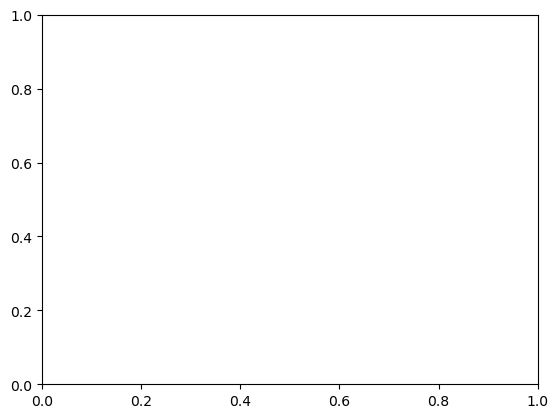

In [27]:
import gymnasium as gym
import time
import signal
import time
import sys
import pickle
import os 

env = make_env("MountainCarContinuous-v0", "videos/", 50)
record = False
gamma = 0.9
alpha = 0.001
beta = 0.002
batch_size = 64
tau = 0.01 
soft_update = True 
noe = 500
max_steps = 100000
is_tg = True 
tg_bot_freq_epi = 20
record = True 
mem_size = 5000000
noise = 0.5
    
    
if not os.path.exists("videos"): 
    os.mkdir("videos")

if not os.path.exists("test_videos"):
    os.mkdir("test_videos")


if __name__ == "__main__": 
    
    try: 
        manage_memory()
        trainer = Trainer(env, gamma, alpha, beta, batch_size, tau,
                          soft_update, noe, max_steps, is_tg,
                          tg_bot_freq_epi, record, mem_size, noise
                )
        episode_rewards, avg_rewards, best_reward = trainer.train_rl_model()
        
        with open("ddpg_episode_rewards.obj", "wb") as f: 
            pickle.dump(episode_rewards, f)
        
        with open("ddpg_avg_rewards.obj", "wb") as f: 
            pickle.dump(avg_rewards, f)
        
        x = [i+1 for i in range(len(episode_rewards))]
        plot_learning_curve(x, episode_rewards, "ddpg_con_mountain_car")

       # model_path = "models/lunarlander_DQN_q_value/"

        #evaluator = Eval(env, action_space, model_path, "vanilla_dqn_lunarlander", 10)
        #evaluator.test()
        
    except Exception as error: 
        raise error
        
   # eval_model(env, "keras model", "videos/", fps=10)
